# aptos 2019 blindness detection

detect diabetic retinopathy to stop blindness before it's too late

this notebook is heavily referencing [duc nguyen's competition notebook](https://www.kaggle.com/code/mathormad/aptos-resnet50-baseline) and is meant to be a study tool

## understanding diabetic retinopathy

## Importing Libraries

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Data

In [14]:
train_df = pd.read_csv('./data/blindness-detection/train.csv')
test_df = pd.read_csv('./data/blindness-detection/test.csv')

# image_directory = './data/blindness-detection/train_images/'

# image_files = os.listdir(image_directory)

# resized_image_directory = './data/blindness-detection/train_images_resized/'
# os.makedirs(resized_image_directory, exist_ok=True)

# for image_file in image_files:
#     image_path = os.path.join(image_directory, image_file)
#     with Image.open(image_path) as img:
#         resized_img = img.resize((224, 224))
#         resized_img.save(os.path.join(resized_image_directory, image_file))

# print(f"All images resized and saved to {resized_image_directory}")

All images resized and saved to ./data/blindness-detection/train_images_resized/


<Axes: >

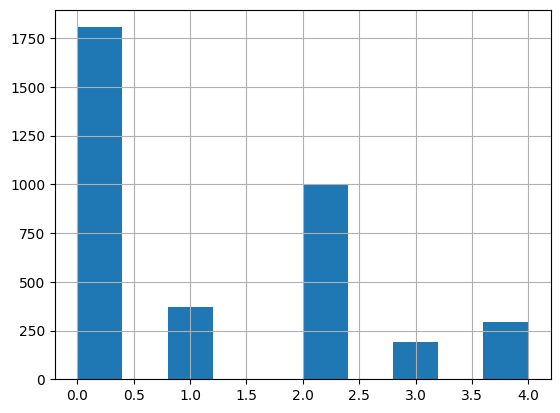

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./data/blindness-detection/train.csv')
test_df = pd.read_csv('./data/blindness-detection/test.csv')

x_train = train_df['image_id']
y_train = train_df['diagnosis']

x_test = test_df['image_id']
y_test = test_df['diagnosis']

IMG_SIZE = 224  # resNet input size is typically 224x224

# preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# create training data generator
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./data/blindness-detection/train_images_resized/', 
    x_col='image_id',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

# create validation data generator
val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,  # Use train_df for validation as well
    directory='./data/blindness-detection/train_images_resized/',
    x_col='image_id',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation'
)


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the ResNet50 base model
base_model.trainable = False

# Create a new model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='sigmoid')  
])

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Or 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)